# Survival Analysis
- Reference
  - https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#

## Import

In [ ]:
import pandas as pd
from lifelines import CoxPHFitter

## Data
- Telco customer churn: IBM dataset
  - source: https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset?resource=download
  - 内容：固定電話およびインターネットサービスを提供している架空の電話会社における顧客の解約に関するデータ
  - 変数（適当に抜粋）：

    - 契約期間
      - Tenure Months（当月までの継続月数）

    - イベント発生有無
      - Churn Value（当月解約有無）: 1=当月に解約した, 0=当月に解約していない（継続中）
        - 前月以前に解約した顧客は含まれていない模様
    
    - 説明変数

      - 顧客属性
        - Gender (性別): Male, Female
        - City (居住地): Los Angeles, Beverly Hills, etc
        - Senior Citizen (65歳以上か): Yes, No
        - Partner (パートナーがいるか): Yes, No
        - Dependents (扶養家族がいるか): Yes, No
      
      - 契約状況
        - Phone Service (固定電話を契約しているか): Yes, No
        - Multiple Lines (複数の電話回線を契約しているか): Yes, No, No phone service
        - Internet Service (インターネットを契約しているか): DSL, Fiber optic, No
        - Contract (契約タイプ): Month-to-Month, One Year, Two Year.
      
      - 利用料金関連
        - Paperless Billing (請求書を電子で受け取るか): Yes, No
        - Payment Method (支払い方法): Mailed check, Electronic check, Bank transfer (automatic), Credit card (automatic)
        - Monthly Charge (月額利用料金)
        - Total Charges (これまでの利用料金計)

      - 追加サービス利用有無
        - Online Security (online serurity serviceに加入しているか): Yes, No, No internet service
        - Online Backup (online backup serviceに加入しているか): Yes, No, No internet service
        - Device Protection (device protection planに加入しているか): Yes, No, No internet service
        - Tech Support (technical support planに加入しているか): Yes, No, No internet service
        - Streaming TV (インターネットを利用してTVを観ているか): Yes, No, No internet service
        - Streaming Movies (インターネットを利用して映画を観ているか): Yes, No, No internet service


In [ ]:
# Load
df = pd.read_csv('Telco_customer_churn.csv', index_col=0, encoding='utf-8').reset_index()
df.head(1)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer


In [ ]:
# Check
print(df.shape)
print(df.columns)

(7043, 33)
Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip_Code',
       'Lat_Long', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges', 'Churn_Label', 'Churn_Value',
       'Churn_Score', 'CLTV', 'Churn_Reason'],
      dtype='object')


In [ ]:
# 加工

# カラム名の空白を_で置き換え
df.columns = df.columns.str.replace(' ', '_')

# Yes/Noを1/0に変換
list_of_cols = ['Senior_Citizen', 'Partner', 'Dependents', 'Phone_Service', 'Paperless_Billing']
df[list_of_cols] = df[list_of_cols].replace({'Yes': 1, 'No': 0})

# その他変換
df['Gender'] = df['Gender'].replace({'Male':1, 'Female':0})

df.head(3)

,CustomerID,Count,Country,State,City,Zip_Code,Lat_Long,Latitude,Longitude,Gender,...,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Label,Churn_Value,Churn_Score,CLTV,Churn_Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,1,...,Month-to-month,1,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,0,...,Month-to-month,1,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,0,...,Month-to-month,1,Electronic check,99.65,820.5,Yes,1,86,5372,Moved


In [ ]:
# モデルに突っ込む用df
vars = ['Tenure_Months', 'Churn_Value', 'Gender', 'Senior_Citizen', 'Partner', 'Dependents', 'Phone_Service', 'Paperless_Billing']
df_limited = df[vars]
df_limited.head(3)

,Tenure_Months,Churn_Value,Gender,Senior_Citizen,Partner,Dependents,Phone_Service,Paperless_Billing
0,2,1,1,0,0,0,1,1
1,2,1,0,0,0,1,1,1
2,8,1,0,0,0,1,1,1


In [ ]:
# correlation
df_limited.corr()

,Tenure_Months,Churn_Value,Gender,Senior_Citizen,Partner,Dependents,Phone_Service,Paperless_Billing
Tenure_Months,1.000000,-0.352229,0.005106,0.016567,0.379697,0.131376,0.008448,0.006152
Churn_Value,-0.352229,1.000000,-0.008612,0.150889,-0.150448,-0.248542,0.011942,0.191825
Gender,0.005106,-0.008612,1.000000,-0.001874,-0.001808,0.005229,-0.006488,-0.011754
Senior_Citizen,0.016567,0.150889,-0.001874,1.000000,0.016479,-0.174396,0.008576,0.156530
Partner,0.379697,-0.150448,-0.001808,0.016479,1.000000,0.363430,0.017706,-0.014877
Dependents,0.131376,-0.248542,0.005229,-0.174396,0.363430,1.000000,0.000625,-0.118963
Phone_Service,0.008448,0.011942,-0.006488,0.008576,0.017706,0.000625,1.000000,0.016505
Paperless_Billing,0.006152,0.191825,-0.011754,0.156530,-0.014877,-0.118963,0.016505,1.000000


## Estimation
- Cox比例ハザードモデル
  - 準備
    - 解約率（確率密度関数ver.）
      - f(t) = 期間tが経過した時点で（ある時点tにおいて）解約する確率
    - 解約率（累積分布関数ver.）
      - F(t) = 期間tが経過するまでに（ある時点tまでのいずれかの時点で）解約している確率
    - 生存継続率（継続率）関数
      - S(t) = 期間tが経過するまで契約を継続している確率（=1-F(t)）
    - ハザード関数
      - h(t) = 時点tにおいて解約する確率 / 時点tまで契約を継続している確率（=f(t)/S(t)）
      - ある時点tまで継続したという条件の下で時点tにおいて解約する確率（＝条件付き確率）
      - なぜハザード関数を考えるか
        - t=1における解約者数とt=10における解約者数を比較すると，通常は後者の方が小さくなる
        - 故に単純に解約率で比較すると，仮に解約のしやすさがt=1とt=30で等しかったとしても後者の方が小さくなる
        - ハザード関数を考えることで，解約のしやすさを正しく把握することができる
  - 推定式：$h(t) = h_{0}(t) exp(\beta_{1}x_{1} + \beta_{2}x_{2} + \cdots + \beta_{k}x_{k})$
    - 概要
      - 全ての顧客に共通のベースラインハザード$h_{0}(t)$と，顧客ごとの相対ハザード$exp(\beta_{1}x_{1} + \beta_{2}x_{2} + \cdots + \beta_{k}x_{k})$をかけ合わせることで顧客ごとのハザード率$h(t)$が決まる（相対ハザードは各顧客の説明変数の値$x_{1}, x_{2}, \cdots$によって決まる）．
      - 各顧客のハザード率$h(t)$は，全顧客に共通するベースラインハザードの何倍（倍率は説明変数によって決まる），つまりベースラインハザードに比例する形で決まるため，比例ハザードモデルと呼ばれる
      - ベースラインハザード$h_{0}(t)$の形に仮定をおかず，どの説明変数がどの程度ハザード率に影響を与えているかを知ること（$\beta_{1}, \beta_{2}, \cdots$の推定）に主眼を置いたモデルである．
    - 推定方法
      - 最尤法（Maximum Likelihood Estimation: MLE）により推定する
      - ただしベースラインハザードを推定しないため，データが持つ一部の情報のみを利用して推定を行なう．そのため，ここでの尤度は通常の尤度ではなく部分尤度（partial likelihood）となり，部分尤度関数を最大化することにより推定を行なう．

In [ ]:
# Fit
cph = CoxPHFitter()
cph.fit(df_limited, duration_col='Tenure_Months', event_col='Churn_Value')

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

## Result
- Interpretation
  - 説明変数Xのcoefが正：Xはハザード率を上げる（解約率を上げる方向に働いている）＝Xが大きいほど早く解約する確率が高い（契約期間が短い）
  - a one unit increase in X means the baseline hazard will increase by a factor of exp(coef)

In [ ]:
# Result
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'Tenure_Months'
                event col = 'Churn_Value'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15190.23
         time fit was run = 2024-01-20 07:45:51 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
Gender             -0.01       0.99       0.05            -0.10             0.08                 0.91                 1.09
Senior_Citizen      0.30       1.35       0.05             0.20             0.41                 1.22                 1.51
Partner            -0.72       0.48       0.05            -0.82            -0.63                 0.44                 0.53
Dependents         -1.37       0.25       0.10            -1.57            -1.17                 0.21                 0.31
Phone_Service       0.09       1.10       0.08            -0.07             0.25                 0.94                 1.28
Paperless_Billing   0.60       1.81       0.05             0.49             0.70                 1.63                 2.02

                    cmp to      z      p   -log2(p)
covariate                                          
Gender                0.00  -0.17   0.87       0.21
Senior_Citizen        0.00   5.62 <0.005      25.65
Partner               0.00 -14.37 <0.005     153.18
Dependents            0.00 -13.30 <0.005     131.66
Phone_Service         0.00   1.15   0.25       1.99
Paperless_Billing     0.00  11.05 <0.005      91.88
---
Concordance = 0.69
Partial AIC = 30392.47
log-likelihood ratio test = 925.61 on 6 df
-log2(p) of ll-ratio test = 650.97

## Survival Function
- 顧客別契約月数別生存確率（生存関数）

In [ ]:
surv_func = cph.predict_survival_function(df_limited)
surv_func

,0,1,2,3,4,5,6,7,8,9,...,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.909824,0.976124,0.976124,0.988364,0.976306,0.974896,0.889829,0.949245,0.988453,0.977258,...,0.909157,0.966403,0.909824,0.909824,0.953262,0.909157,0.988453,0.988364,0.989384,0.909824
2.0,0.879054,0.967574,0.967574,0.984161,0.967820,0.965914,0.852807,0.931414,0.984282,0.969108,...,0.878174,0.954454,0.879054,0.879054,0.936795,0.878174,0.984282,0.984161,0.985547,0.879054
3.0,0.855093,0.960760,0.960760,0.980798,0.961057,0.958759,0.824188,0.917334,0.980945,0.962610,...,0.854053,0.944963,0.855093,0.855093,0.923773,0.854053,0.980945,0.980798,0.982476,0.855093
4.0,0.833609,0.954529,0.954529,0.977712,0.954872,0.952218,0.798687,0.904558,0.977882,0.956666,...,0.832431,0.936308,0.833609,0.833609,0.911944,0.832431,0.977882,0.977712,0.979657,0.833609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68.0,0.389622,0.785820,0.785820,0.889817,0.787282,0.776013,0.312163,0.594801,0.890618,0.794974,...,0.386778,0.711165,0.389622,0.389622,0.620390,0.386778,0.890618,0.889817,0.899022,0.389622
69.0,0.379219,0.780402,0.780402,0.886839,0.781895,0.770384,0.301902,0.585995,0.887661,0.789754,...,0.376373,0.704240,0.379219,0.379219,0.611944,0.376373,0.887661,0.886839,0.896279,0.379219
70.0,0.363177,0.771823,0.771823,0.882104,0.773366,0.761477,0.286206,0.572199,0.882958,0.781488,...,0.360329,0.693317,0.363177,0.363177,0.598692,0.360329,0.882958,0.882104,0.891914,0.363177
71.0,0.352777,0.766111,0.766111,0.878936,0.767686,0.755549,0.276118,0.563109,0.879811,0.775981,...,0.349933,0.686072,0.352777,0.352777,0.589947,0.349933,0.879811,0.878936,0.888992,0.352777


## Plotting the effect of varying a covariate
- 他の説明変数を一定にしたままある説明変数を変化させたときに生存関数がどのように変化するか

<Axes: >

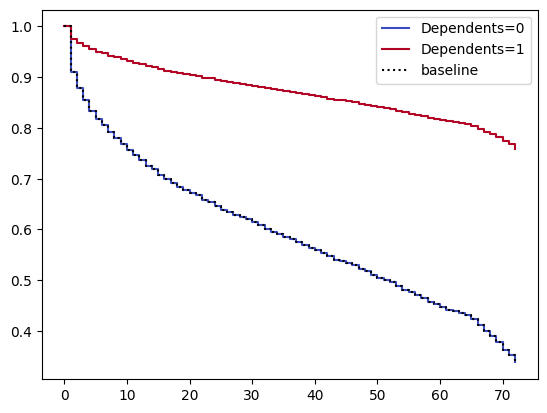

In [ ]:
# Dependents = 0と1の顧客の生存関数をプロット（他の説明変数は固定）
cph.plot_partial_effects_on_outcome(covariates='Dependents', values=[0, 1], cmap='coolwarm')

## Checking the proportional hazards assumption